#  NBA BASE 🏀

<font color=orange> IN ORDER TO RUN THIS NOTEBOOK YOU WILL NEED AN OPENAI API KEY and A PINECONE API KEY</font>

## imports

In [ ]:
!pip install openai langchain llama_index==0.6.18 pypdf PyCryptodome gradio
!pip install bs4
!pip install wikipedia
!pip install pinecone-client
!pip install transformers
from bs4 import BeautifulSoup
import numpy as np
import requests
import re
import pandas as pd
import io
import csv
import wikipedia
from typing import Any, List
import json
import os
import re
from urllib.request import urlopen
import openai
from pathlib import Path
from llama_index import download_loader
from llama_index import (
    GPTVectorStoreIndex,
    GPTSimpleKeywordTableIndex,
    SimpleDirectoryReader,
    LLMPredictor,
    ServiceContext
)
from llama_index.vector_stores import PineconeVectorStore
from llama_index import StorageContext, ServiceContext, GPTVectorStoreIndex, LLMPredictor, PromptHelper, SimpleDirectoryReader, load_index_from_storage
from langchain.llms.openai import OpenAIChat
import pinecone
from langchain.chat_models import ChatOpenAI

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 448.6/448.6 kB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.3/249.3 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 55.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 47.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 70.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 46.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━

## Wikipedia Dataset (or as I like to call it articles upon articles)

In an attempt to find and load as much information from wikipedia as possible I created a script that can be found on [life of baka ](https://github.com/lifeofbaka/Wikipedia-Page-Name-Downloader/blob/main/main.py) that cycles through wikipedia and returns the name of every page and stores it in a text file. In order to make working with this information easier, I've also created what I would refer to as a file cutter which takes the output file and cuts it into files called wiki#.txt where each wiki text file contain a piece of the complete wiki text up to 24.1 MB. Each of these files can now be read one at a time to Access information on a selection of topics...

In [ ]:
# NOTE CURRENT WIKI TEXT FILE EXCEEDS 8 MILLION LINES AND HAS NOT BEEN COMPLETED.
# CURRENT LETTER VALUE: A - L
# ALL VALUES STARTING WITH A NUMBER OR SYMBOL ARE PRESENT

In [ ]:
#wiki links
wiki_txt_links = ['https://raw.githubusercontent.com/lifeofbaka/Datasets/main/Wikipedia/wiki' + str(i)+ '.txt' for i in range(1,9)] #if wiki size changes update the range.

### Topic of Interest values: NBA Teams

In [ ]:
#topic generator is too big for free pinecone account....
'''
basketball_teams = [
    "Atlanta Hawks",
    "Boston Celtics",
    "Brooklyn Nets",
    "Charlotte Hornets",
    "Chicago Bulls",
    "Cleveland Cavaliers",
    "Dallas Mavericks",
    "Denver Nuggets",
    "Detroit Pistons",
    "Golden State Warriors",
    "Houston Rockets",
    "Indiana Pacers",
    "Los Angeles Clippers",
    "Los Angeles Lakers",
    "Memphis Grizzlies",
    "Miami Heat",
    "Milwaukee Bucks",
    "Minnesota Timberwolves",
    "New Orleans Pelicans",
    "New York Knicks",
    "Oklahoma City Thunder",
    "Orlando Magic",
    "Philadelphia 76ers",
    "Phoenix Suns",
    "Portland Trail Blazers",
    "Sacramento Kings",
    "San Antonio Spurs",
    "Toronto Raptors",
    "Utah Jazz",
    "Washington Wizards",
    "Anderson Packers",
    "Baltimore Bullets",
    "Buffalo Braves",
    "Chicago Packers",
    "Chicago Stags",
    "Cincinnati Royals",
    "Cleveland Rebels",
    "Denver Rockets",
    "Detroit Falcons",
    "Indianapolis Olympians",
    "Indianapolis Jets",
    "Indianapolis Kautskys",
    "Kansas City Kings",
    "Kansas City-Omaha Kings",
    "Milwaukee Hawks",
    "Minneapolis Lakers",
    "New Jersey Americans",
    "New Orleans Buccaneers",
    "New Orleans Jazz",
    "Philadelphia Warriors",
    "Pittsburgh Ironmen",
    "Providence Steamrollers",
    "San Diego Clippers",
    "San Diego Conquistadors",
    "San Francisco Warriors",
    "Sheboygan Red Skins",
    "St. Louis Bombers",
    "Syracuse Nationals",
    "Toronto Huskies",
    "Toronto Raptors (1995-1996)",
    "Vancouver Grizzlies",
    "Washington Capitols",
    "Waterloo Hawks",
    "Washington Bullets"
]
'''

'\nbasketball_teams = [\n    "Atlanta Hawks",\n    "Boston Celtics",\n    "Brooklyn Nets",\n    "Charlotte Hornets",\n    "Chicago Bulls",\n    "Cleveland Cavaliers",\n    "Dallas Mavericks",\n    "Denver Nuggets",\n    "Detroit Pistons",\n    "Golden State Warriors",\n    "Houston Rockets",\n    "Indiana Pacers",\n    "Los Angeles Clippers",\n    "Los Angeles Lakers",\n    "Memphis Grizzlies",\n    "Miami Heat",\n    "Milwaukee Bucks",\n    "Minnesota Timberwolves",\n    "New Orleans Pelicans",\n    "New York Knicks",\n    "Oklahoma City Thunder",\n    "Orlando Magic",\n    "Philadelphia 76ers",\n    "Phoenix Suns",\n    "Portland Trail Blazers",\n    "Sacramento Kings",\n    "San Antonio Spurs",\n    "Toronto Raptors",\n    "Utah Jazz",\n    "Washington Wizards",\n    "Anderson Packers",\n    "Baltimore Bullets",\n    "Buffalo Braves",\n    "Chicago Packers",\n    "Chicago Stags",\n    "Cincinnati Royals",\n    "Cleveland Rebels",\n    "Denver Rockets",\n    "Detroit Falcons",\n    "

### Smaller test case values: Single Team

In [ ]:
basketball_teams = [ "Chicago Bulls"]

In [ ]:
len(basketball_teams)

1

### Wiki Extraction (all case values IN wiki texts)

The next step in this process was to find every wiki that had one of the values in the Topic Case or Small Case. The values would then be added to a list to be read later on in the process. <br> <br>
== Note ==<br>

<font color=red>Wikipedia uses multiple url values for redirection meaning that several article names can direct you to the same article.</font>

In [ ]:
nba_wiki = []
for i in range(len(wiki_txt_links)):
   data = urlopen(wiki_txt_links[i]) # it's a file like object and works just like a file
   articles = [line.strip() for line in data] # files are iterable
   for team in basketball_teams:
      for topic in articles:
        if team in str(topic):
          pattern = r'\\xe2\\x80\\x93'
          matches = re.findall(pattern, str(topic))
          if not matches:
            nba_wiki.append(str(topic)[2:-1])
print (len(nba_wiki))

140


In [ ]:
nba_wiki

['1966-67 Chicago Bulls',
 '1966-67 Chicago Bulls season',
 '1967-68 Chicago Bulls',
 '1967-68 Chicago Bulls season',
 '1968-69 Chicago Bulls',
 '1968-69 Chicago Bulls season',
 '1969-70 Chicago Bulls',
 '1969-70 Chicago Bulls season',
 '1970-71 Chicago Bulls',
 '1970-71 Chicago Bulls season',
 '1971-72 Chicago Bulls',
 '1971-72 Chicago Bulls season',
 '1972-73 Chicago Bulls',
 '1972-73 Chicago Bulls season',
 '1973-74 Chicago Bulls',
 '1973-74 Chicago Bulls season',
 '1974-75 Chicago Bulls',
 '1974-75 Chicago Bulls season',
 '1975-76 Chicago Bulls',
 '1975-76 Chicago Bulls season',
 '1976-77 Chicago Bulls',
 '1976-77 Chicago Bulls season',
 '1977-78 Chicago Bulls',
 '1977-78 Chicago Bulls season',
 '1978-79 Chicago Bulls',
 '1978-79 Chicago Bulls season',
 '1979-80 Chicago Bulls',
 '1979-80 Chicago Bulls season',
 '1980-81 Chicago Bulls',
 '1980-81 Chicago Bulls season',
 '1981-82 Chicago Bulls',
 '1981-82 Chicago Bulls season',
 '1982-83 Chicago Bulls',
 '1982-83 Chicago Bulls season

In [ ]:
nba_wiki_ = set()
for i in range(len(nba_wiki)):
  try:
    if nba_wiki[i] in nba_wiki[i+1]:
      nba_wiki_.add(nba_wiki[i+1])
    else:
      nba_wiki_.add(nba_wiki(i))
  except:
    nba_wiki_.add(nba_wiki[i])
nba_wiki_ = list(nba_wiki_)
print (len(nba_wiki_))

83


In [ ]:
sorted(nba_wiki_)

['1966-67 Chicago Bulls season',
 '1967-68 Chicago Bulls season',
 '1968-69 Chicago Bulls season',
 '1969-70 Chicago Bulls season',
 '1970-71 Chicago Bulls season',
 '1971-72 Chicago Bulls season',
 '1972-73 Chicago Bulls season',
 '1973-74 Chicago Bulls season',
 '1974-75 Chicago Bulls season',
 '1975-76 Chicago Bulls season',
 '1976-77 Chicago Bulls season',
 '1977-78 Chicago Bulls season',
 '1978-79 Chicago Bulls season',
 '1979-80 Chicago Bulls season',
 '1980-81 Chicago Bulls season',
 '1981-82 Chicago Bulls season',
 '1982-83 Chicago Bulls season',
 '1983-84 Chicago Bulls season',
 '1984-85 Chicago Bulls season',
 '1985-86 Chicago Bulls season',
 '1986-87 Chicago Bulls season',
 '1987-88 Chicago Bulls season',
 '1988-89 Chicago Bulls season',
 '1989-90 Chicago Bulls season',
 '1990-91 Chicago Bulls season',
 '1991-92 Chicago Bulls season',
 '1992-93 Chicago Bulls season',
 '1993-94 Chicago Bulls season',
 '1994-95 Chicago Bulls season',
 '1995-96 Chicago Bulls season',
 '1996 Chi

At this point I was able to remove files which I had identified to be duplicates. After printing the outputs I noticed a few outliers which I list below to be removed. None the less although these have been removed there may still be other outliers and in order the remove a check must be run on the summary of each file.

In [ ]:
to_remove = ['(football)','(NHL)', '(AFL)', '(hockey)', '(AFL, 1926)', '(American football)', '(WFL)', '(UHL)']

In [ ]:
for line in nba_wiki_:
  for item in to_remove:
    if item in line:
      print (line)
      nba_wiki_.remove(line)
print (len(nba_wiki_))

Chicago Bulls (AFL, 1926)
Chicago Bulls (American football)
Chicago Bulls (AFL)
80


### Custom wikipedia Dictionary Builder <font color ='red'>(Specific to values in Topic case)</font>

Below is the <font color='green'>load data function</font>. The function is reliant on a number of table finder functions that have also been assigned below as <font color='green'>draft picks</font> and <font color='green'>roster</font>. The functions find specific table values within the pagent context using Beautiful Soup then output a dictionary from a working dataframe which is then stored within the results dictionary and usable sub topic storage for JSON.<br><br>
<font color='red'> This code still needs to be tweaked and currently only returns Draft Picks and Rosters for some Seasons with working indexes. </font>

In [ ]:

#test
#articles = ['1968–69 Atlanta Hawks season','1968–69_Chicago_Bulls_season']


#WIKIPEDIA PULL
def load_data( pages: List[str], lang: str = "en", **load_kwargs: Any):
    results = []
    for page in pages:
        wikipedia.set_lang(lang)
        try:
          page_content = wikipedia.page(page, **load_kwargs).content
          summary = page_content
          matches = re.findall(r'==\s(.*?)\s==', summary)

          if 'Draft picks' in matches:
              draftpick = draft_picks(page)
          else:
              draftpick = ''
          if 'Roster' in matches:
              team_roster = roster(page)
              pull.append(page)
          else:
              team_roster = ['','']

          data = {page: {"summary": summary, "Draft Pick": draftpick, "Coach": team_roster[0], "Roster": team_roster[1]}}
          results.append(data)
        except:
          pass

    return results

#Tables = re.findall(r"\n== (.*?) ==\n", summary[0])
#print (Tables)






#################################################################################################



def draft_picks(article):
    url = requests.get(f'https://en.wikipedia.org/wiki/{article}').content
    soup = BeautifulSoup(url, 'html.parser')
    tables = []
    for i in soup.find_all('table'):
        tables.append(i)
    for i in range(len(tables)):
        try:
          table_text = tables[i].text
          table_text = table_text.split('\n')

          # find table columns
          col_finder = ' '.join(table_text)
          cols = col_finder.split('   ')
          cols = cols[0].split(' ')

          result_cols = []
          for item in cols:
              if item != '':
                  result_cols.append(item)


          #find table data
          result = []
          pattern = r"(?<=\xa0)\w++"
          for record in table_text:
              match = re.search(r"\xa0(.*)", record)
              if match:
                  result.append(match.group(1))
              else:
                  if record != '':
                      result.append(record)
          result = result[len(result_cols):]
          result = np.array(result)
          shaper = (len(result_cols),int(result.shape[0]/len(result_cols)))

          result = result.reshape(shaper[1],shaper[0])

          df = pd.DataFrame(result, columns=result_cols)
          dictionary = df.to_dict()
          return dictionary
        except:
            pass
    return "could not find table"


def roster(article):
    url = requests.get(f'https://en.wikipedia.org/wiki/{article}').content
    soup = BeautifulSoup(url, 'html.parser')
    tables = []
    for i in soup.find_all('table'):
        tables.append(i)

    for i in range(len(tables)):
        try:
            table_text = tables[i].text
            table_text = table_text.split('\n')

            # find table columns
            col_finder = ' '.join(table_text)
            cols = col_finder.split('   ')
            cols = ' '.join(cols[1:4]).split(' ')

            result_cols = []
            for i in cols:
                if i != '':
                    result_cols.append(i)
            result_cols = result_cols[2:7] + [' '.join(result_cols[7:9])] + result_cols[-1:]


            #find table data
            result = []
            for record in table_text:
                matches = re.findall(r'\xa0', record)
                if matches:
                    result.append(record.replace('\xa0',' '))
                else:
                    if record != '':
                        result.append(record)
            result = result[result.index('From') + 1:result.index('Head coach')]


            #Head Coach


            try:

                shaper = (len(result_cols), int(len(result) / len(result_cols)))
                n_result = np.array(result)
                result = n_result.reshape(shaper[1], shaper[0])

                df = pd.DataFrame(result, columns=result_cols)
                roster_dictionary = df.to_dict()
                coach = {table_text[table_text.index('Head coach'): table_text.index('Head coach') + 1][0]:
                             table_text[table_text.index('Head coach') + 1: table_text.index('Head coach') + 2][0]}

                return coach, roster_dictionary
            except:
                result_cols.remove('DOB (YYYY-MM-DD)')
                result = np.array(result)
                shaper = (len(result_cols), int(result.shape[0] / len(result_cols)))
                result = result.reshape(shaper[1], shaper[0])

                df = pd.DataFrame(result, columns=result_cols)
                new_column = [None for i in range(len(df))]
                position = df.columns.get_loc('Weight') + 1
                df.insert(position, 'DOB (YYYY-MM-DD)', new_column)
                roster_dictionary = df.to_dict()
                coach = {table_text[table_text.index('Head coach'): table_text.index('Head coach') + 1][0]:
                             table_text[table_text.index('Head coach') + 2: table_text.index('Head coach') + 3][0]}

                return coach, roster_dictionary
        except:
            pass
    return "could not find table"

==Note to Self ==<br>
Testing Table finder... Still need to add additional trials. Table finder missed 28 out of 80 values sent.

In [ ]:
test_i = nba_wiki_.index("1984-85 Chicago Bulls season")
test_i

29

In [ ]:
nba_wiki_[29]

'1984-85 Chicago Bulls season'

In [ ]:
draft_picks([nba_wiki_[29]])

'could not find table'

## JSON

At this point the load function is called for every values that was previously extracted and a JSON file is written into the contents.

In [ ]:
len(nba_wiki_)

80

In [ ]:
pull = []
for value in load_data(pages=sorted(nba_wiki_)):
    for key in value:
      file_name = key.replace("-"," ")
      file_name = file_name.replace(" ","_")
      pull.append(file_name)
      with open(f"{file_name}.json", "w") as file:
        json.dump(value, file, indent=4)

<ipython-input-59-910a1a48f533>:83: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  dictionary = df.to_dict()
<ipython-input-59-910a1a48f533>:83: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  dictionary = df.to_dict()
<ipython-input-59-910a1a48f533>:83: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  dictionary = df.to_dict()
<ipython-input-59-910a1a48f533>:83: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  dictionary = df.to_dict()
<ipython-input-59-910a1a48f533>:83: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  dictionary = df.to_dict()
<ipython-input-59-910a1a48f533>:83: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  dictionary = df.to_dict()
<ipython-input-59-910a1a48f533>:83: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  dictionary = df.to_dict()
<ipython-inpu

In [ ]:
#files in content
sorted(pull)

['1966-67 Chicago Bulls season',
 '1966_67_Chicago_Bulls_season',
 '1967-68 Chicago Bulls season',
 '1967_68_Chicago_Bulls_season',
 '1968-69 Chicago Bulls season',
 '1968_69_Chicago_Bulls_season',
 '1969-70 Chicago Bulls season',
 '1969_70_Chicago_Bulls_season',
 '1970-71 Chicago Bulls season',
 '1970_71_Chicago_Bulls_season',
 '1971-72 Chicago Bulls season',
 '1971_72_Chicago_Bulls_season',
 '1972-73 Chicago Bulls season',
 '1972_73_Chicago_Bulls_season',
 '1973-74 Chicago Bulls season',
 '1973_74_Chicago_Bulls_season',
 '1974-75 Chicago Bulls season',
 '1974_75_Chicago_Bulls_season',
 '1975-76 Chicago Bulls season',
 '1975_76_Chicago_Bulls_season',
 '1976-77 Chicago Bulls season',
 '1976_77_Chicago_Bulls_season',
 '1977-78 Chicago Bulls season',
 '1977_78_Chicago_Bulls_season',
 '1978-79 Chicago Bulls season',
 '1978_79_Chicago_Bulls_season',
 '1979-80 Chicago Bulls season',
 '1979_80_Chicago_Bulls_season',
 '1980-81 Chicago Bulls season',
 '1980_81_Chicago_Bulls_season',
 '1981-82 

In [ ]:
print (len(pull))
print(len(nba_wiki_))

140
80


## Loading JSONS into LLAMA Index 🦙

### Single Document Test Case

In [ ]:
print (os.listdir())
print (len(os.listdir()))

['.config', '1995_96_Chicago_Bulls_season.json', '1977_78_Chicago_Bulls_season.json', '2016_17_Chicago_Bulls_season.json', '1979_80_Chicago_Bulls_season.json', 'Chicago_Bulls_records.json', '1991_92_Chicago_Bulls_season.json', 'Chicago_Bulls_all_time_roster.json', '1966_67_Chicago_Bulls_season.json', 'Chicago_Bulls_College_Prep.json', '1999_00_Chicago_Bulls_season.json', '1998_99_Chicago_Bulls_season.json', '2003_04_Chicago_Bulls_season.json', 'Chicago_Bulls_seasons.json', '1996_97_Chicago_Bulls_season.json', '2000_01_Chicago_Bulls_season.json', '1980_81_Chicago_Bulls_season.json', '2021_22_Chicago_Bulls_season.json', '1967_68_Chicago_Bulls_season.json', '2022_23_Chicago_Bulls_season.json', '1989_90_Chicago_Bulls_season.json', 'Chicago_Bulls_record_book.json', 'Chicago_Bulls_championship_riots.json', '2018_19_Chicago_Bulls_season.json', '2005_06_Chicago_Bulls_season.json', '2007_08_Chicago_Bulls_season.json', '1999_2000_Chicago_Bulls_season.json', '2019_20_Chicago_Bulls_season.json', '

In [ ]:
p =os.listdir()[1:-1]

In [ ]:
file_path = "/content/"

In [ ]:
pull_ = set(i for i in pull)
pull

['1966-67 Chicago Bulls season',
 '1967-68 Chicago Bulls season',
 '1968-69 Chicago Bulls season',
 '1969-70 Chicago Bulls season',
 '1970-71 Chicago Bulls season',
 '1971-72 Chicago Bulls season',
 '1972-73 Chicago Bulls season',
 '1973-74 Chicago Bulls season',
 '1974-75 Chicago Bulls season',
 '1975-76 Chicago Bulls season',
 '1976-77 Chicago Bulls season',
 '1977-78 Chicago Bulls season',
 '1978-79 Chicago Bulls season',
 '1979-80 Chicago Bulls season',
 '1980-81 Chicago Bulls season',
 '1981-82 Chicago Bulls season',
 '1982-83 Chicago Bulls season',
 '1983-84 Chicago Bulls season',
 '1984-85 Chicago Bulls season',
 '1985-86 Chicago Bulls season',
 '1986-87 Chicago Bulls season',
 '1987-88 Chicago Bulls season',
 '1988-89 Chicago Bulls season',
 '1989-90 Chicago Bulls season',
 '1990-91 Chicago Bulls season',
 '1991-92 Chicago Bulls season',
 '1992-93 Chicago Bulls season',
 '1993-94 Chicago Bulls season',
 '1994-95 Chicago Bulls season',
 '1995-96 Chicago Bulls season',
 '1996 Chi

In [ ]:
paths = []
for i in pull:
  i = i.replace("-", " ")
  i = i.replace(" ",("_"))
  paths.append(file_path +i+".json")

In [ ]:
print(paths[0:2])

['/content/1966_67_Chicago_Bulls_season.json', '/content/1967_68_Chicago_Bulls_season.json']


In [ ]:
from pathlib import Path
from llama_index import download_loader

JSONReader = download_loader("JSONReader")

loader = JSONReader()

In [ ]:
paths[0]

'/content/1966_67_Chicago_Bulls_season.json'

In [ ]:
document = loader.load_data(Path(paths[34]))

In [ ]:
#example of what the fully working JSON file should look like
document

[Document(text='"1999-00 Chicago Bulls season": {\n"summary": "The 1999\\u20132000 NBA season was the Bulls\' 34th season in the National Basketball Association. The Bulls won the Draft Lottery, and selected Elton Brand out of Duke University with the first overall pick in the 1999 NBA draft, and also drafted Ron Artest out of St. John\'s University with the sixteenth overall pick. During the off-season, the team acquired Hersey Hawkins from the Seattle SuperSonics, and signed free agent Fred Hoiberg, and re-signed former Bulls guard B. J. Armstrong, and former Bulls center Will Perdue, who both won championships from the team\'s first three-peat in the early 1990s.However, the Bulls\' struggles continued as they lost 26 of their first 28 games, posting 10 and 11-game losing streaks respectively. Along the way, the team signed free agent Chris Carr, who was previously released by the Golden State Warriors, and also signed three-point specialist Matt Maloney. At midseason, Toni Kuko\\u0

In [ ]:
print('Document ID:', document[0].doc_id, 'Document Hash:', document[0].doc_hash)

Document ID: 9d132d86-f966-47e9-84af-d015a5550d27 Document Hash: 7203405a02c768a4c6ebf14d49a3f2a2618339ebe78e8a71f97acbc461a98478


#### PineCone 🌲

In [ ]:
import os
import openai

# Set your API key as an environment variable.
os.environ['OPENAI_API_KEY'] = "YOUR API KEY"

openai.organization = "YOUR ORGANIZATION"

# Use your API key.
openai.api_key = os.getenv("OPENAI_API_KEY")

In [ ]:
titles = pull

In [ ]:
print(titles[0])
print(len(titles))

1966-67 Chicago Bulls season
140


In [ ]:
from llama_index.storage.storage_context import StorageContext

api_key="YOUR API KEY"
environment = "YOUR ENVIRONMENT"

os.environ['PINECONE_API_KEY'] = api_key
# install initialize and store vectors in Pinecone


import pinecone
index_name = "nbabase"

pinecone.init(
    api_key="YOUR API KEY",
    environment = "YOUR ENVIRONMENT"
)

if index_name not in pinecone.list_indexes():
  pinecone.create_index(name=index_name, dimension=1536, metric="cosine")
  # pinecone.create_index(index_name, dimension=len(embeds[0]))
# connect to index
index = pinecone.Index(index_name)
# pinecone.create_index(name=index_name, dimension=1536, metric="cosine")

aa_indices = {}
index_summaries = {}

for pinecone_title, name in zip(titles, paths):
    metadata_filters = {"name": name}
    vector_store = PineconeVectorStore(
        index_name=index_name,
        environment=environment,
        metadata_filters=metadata_filters
    )
    storage_context = StorageContext.from_defaults(vector_store=vector_store)

    #aa_docs = SimpleDirectoryReader(input_files=[i for i in paths]).load_data()


    #try:
    document = loader.load_data(Path(name))
    aa_indices[name] = GPTVectorStoreIndex.from_documents(document, storage_context=storage_context)
    aa_indices[name].index_struct.index_id = pinecone_title
    #except:
    #  pass

    index_summaries[name] = f"Wikipedia article about {name}"

In [ ]:
from llama_index.indices.composability.graph import ComposableGraph

graph = ComposableGraph.from_indices(
    GPTSimpleKeywordTableIndex,
    [index for _, index in aa_indices.items()],
    [summary for _, summary in index_summaries.items()],
    max_keywords_per_chunk=50
)

llm_predictor_chatgpt = LLMPredictor(
    #llm=OpenAIChat(temperature=0, model_name="gpt-4")
    llm=OpenAIChat(temperature=0, model_name="gpt-3.5-turbo")
)
service_context = ServiceContext.from_defaults(llm_predictor=llm_predictor_chatgpt)

custom_query_engines = {
    graph.root_id: graph.root_index.as_query_engine(retriever_mode='simple', service_context=service_context)
}

query_engine = graph.as_query_engine(custom_query_engines=custom_query_engines)

query_str = "Tell me more about the Chicago Bulls"
response_chatgpt = query_engine.query(query_str)

print(response_chatgpt)
print(response_chatgpt.get_formatted_sources())

None



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/usr/local/lib/python3.10/dist-packages/langchain/llms/openai.py:751: UserWarning: You are trying to use a chat model. This way of initializing it is no longer supported. Instead, please use: `from langchain.chat_models import ChatOpenAI`
  warnings.warn(


## NBA BASE Query 🤖 (single Doc.)

In [ ]:
query_str = "Tell me more about the 1968_69_Chicago_Bulls_season"
response_chatgpt = query_engine.query(query_str)

if not response_chatgpt or not response_chatgpt.get_formatted_sources():
    print("I am sorry, but your query is outside the boundaries of what I was trained on.")
else:
    print(response_chatgpt)
    print(response_chatgpt.get_formatted_sources())

The 1968-69 Chicago Bulls season was the team's third season in the NBA. The team was coached by Dick Motta and had players such as Tom Boerwinkle, Bob Boozer, Barry Clemens, Clem Haskins, Bob Love, Dave Newmark, Loy Petersen, Jerry Sloan, Jim Washington, and Bob Weiss on the roster. The team finished the season with a record of 33-48 and did not make the playoffs. Jerry Sloan was recognized for his defensive skills and was named to the NBA All-Defensive First Team and the NBA All-Star Game.
> Source (Doc id: 90266521-c031-4c24-b603-529369ce9051): 
The 1968-69 NBA season was the Bulls' third season in the NBA. The team was coached by Dick Mott...

> Source (Doc id: 6527fca0-5aca-470a-aaae-a862d3f20716): "1968-69 Chicago Bulls season": {
"summary": "The 1968\u201369 NBA season was the Bulls' third se...

> Source (Doc id: a1c23221-238f-42a3-b7af-ad1302a09df7): "1968-69 Chicago Bulls season": {
"summary": "The 1968\u201369 NBA season was the Bulls' third se...


In [ ]:
query_str = "Tell me more about the 1968_69_Chicago_Bulls_season Roster"
response_chatgpt = query_engine.query(query_str)

if not response_chatgpt or not response_chatgpt.get_formatted_sources():
    print("I am sorry, but your query is outside the boundaries of what I was trained on.")
else:
    print(response_chatgpt)
    print(response_chatgpt.get_formatted_sources())

The 1968-69 Chicago Bulls season roster consisted of 10 players with positions of C, F, G, and F. The players' numbers ranged from 4 to 19 and their names were Boerwinkle, Tom; Boozer, Bob; Clemens, Barry; Haskins, Clem; Love, Bob; Newmark, Dave; Petersen, Loy; Sloan, Jerry; Washington, Jim; and Weiss, Bob. The players' heights ranged from 6 ft 2 in (1.88 m) to 7 ft 0 in (2.13 m) and their weights ranged from 180 lb (82 kg) to 265 lb (120 kg). The players were born between 1937-04-26 and 1946-09-11 and attended colleges such as Columbia, Evansville, Kansas State, Ohio Wesleyan, Oregon State, Southern, Tennessee, and Western Kentucky. The head coach of the team was Dick Motta.
> Source (Doc id: dcf5624b-9ed8-449e-aad2-97f4df208f2b): 
The 1968-69 Chicago Bulls season roster consisted of 10 players. The positions of the players we...

> Source (Doc id: 4949916d-0b6d-40a6-b0a0-cff29b763298): "1968-69 Chicago Bulls season": {
"summary": "The 1968\u201369 NBA season was the Bulls' third se..

## LLAMA Index Multi Doc Case

In [ ]:
import gradio as gr

#### Enironment/Loader/Query

In [ ]:
def create_service_context():

    #constraint parameters
    max_input_size = 4096
    num_outputs = 512
    max_chunk_overlap = .5
    chunk_size_limit = 600

    #allows the user to explicitly set certain constraint parameters
    prompt_helper = PromptHelper(max_input_size, num_outputs, max_chunk_overlap, chunk_size_limit=chunk_size_limit)

    #LLMPredictor is a wrapper class around LangChain's LLMChain that allows easy integration into LlamaIndex
    llm_predictor = LLMPredictor(llm=ChatOpenAI(temperature=0.5, model_name="gpt-3.5-turbo", max_tokens=num_outputs))
    #llm_predictor = LLMPredictor(llm=ChatOpenAI(temperature=0.5, model_name="gpt-4", max_tokens=num_outputs))

    #constructs service_context
    service_context = ServiceContext.from_defaults(llm_predictor=llm_predictor, prompt_helper=prompt_helper)
    return service_context

In [ ]:
def data_ingestion_indexing(directory_path):

    #loads data from the specified directory path
    documents = SimpleDirectoryReader(directory_path).load_data()

    #when first building the index
    index = GPTVectorStoreIndex.from_documents(
        documents, service_context=create_service_context()
    )

    #persist index to disk, default "storage" folder
    index.storage_context.persist()

    return index

In [ ]:
def data_querying(input_text):

    #rebuild storage context
    storage_context = StorageContext.from_defaults(persist_dir="./storage")

    #loads index from storage
    index = load_index_from_storage(storage_context, service_context=create_service_context())

    #queries the index with the input text
    response = index.as_query_engine().query(input_text)

    return response.response

#### Loading Data from JSONS

In [ ]:
iface = gr.Interface(fn=data_querying,
                     inputs=gr.components.Textbox(lines=7, label="Enter your text"),
                     outputs="text",
                     title="🏀 Chicago Bulls 🐮")

In [ ]:
index = data_ingestion_indexing("/content")

## Gradio GUI

In [ ]:
iface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://ae54c355c8435dc4a7.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


## SPACE JAM


[https://www.youtube.com/watch?v=J9FImc2LOr8 ](https://www.youtube.com/watch?v=J9FImc2LOr8 )

![Bugs Bunny and Michael Jordan in "Space Jam" Poster](https://wallpapercave.com/wp/kvPCeUv.jpg)




## *Conclusion*

In Conclusion this was a very interesting experiment in finding data, storing data contents and to then read and store as vectors. I believe that this could greatly improve AI performance and be applied to other cases. Through this process I found that using a JSON file for storing the elements I could have additional information on each topic aside from the base summary. This was a learning process for me and found that the back and forth between trial and error helped me achieve the final outcome.


---

Next Steps... <br>

First of all, I would like to add more cases to this model application. I have the data available to return every team so why not? This test case showed me that it does work and that it is returning accurate information.<br>

After, I would like to work on the speed an efficiency to return results much faster.<br><br>

If possible... <br>
Currently Each JSON only contains 3 data inputs: Page Summary, Drafts, and Roster. I would like to include Season and Playoff information as well to improve on the information available.

## Some Previously Asked Questions

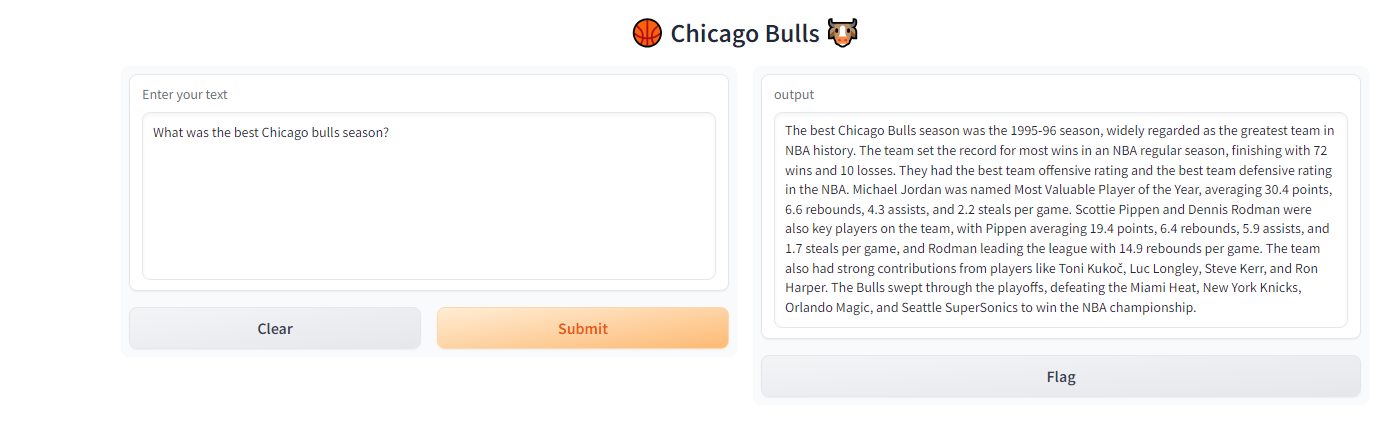

Because the data does not have player statistics it can not anwer the question below:

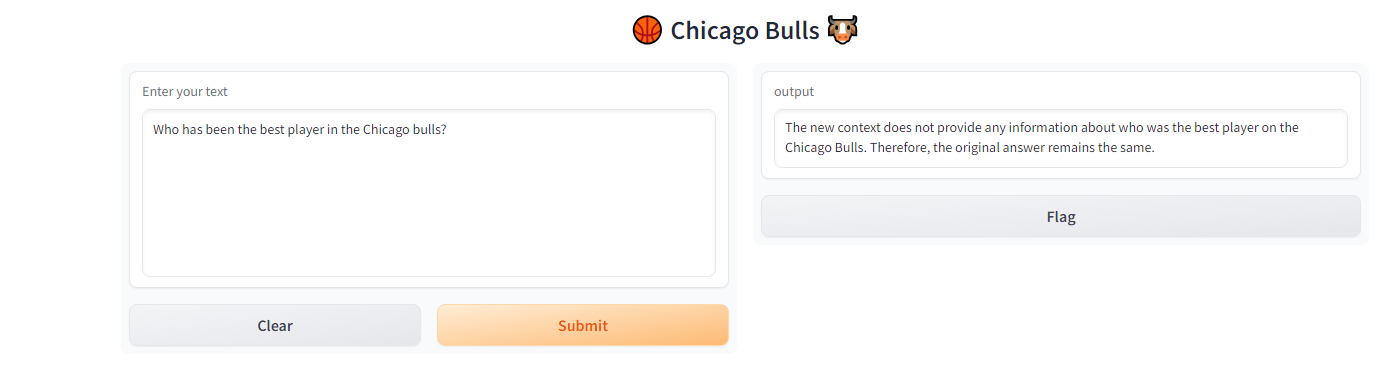

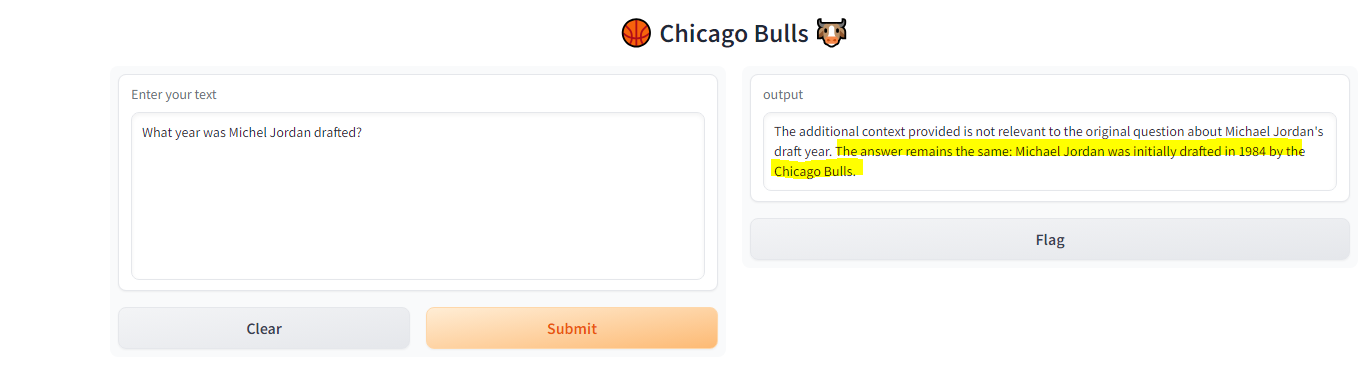

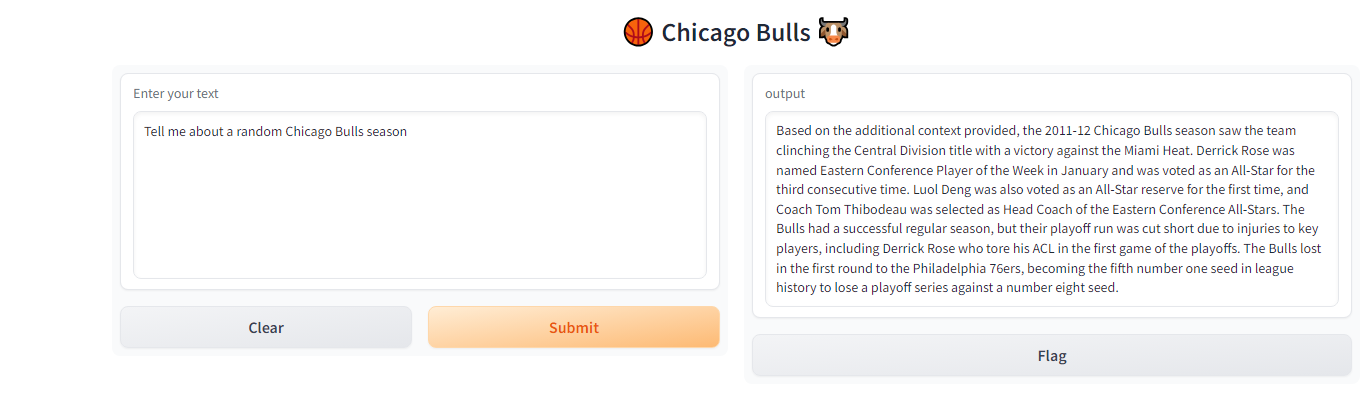